In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from scipy.stats import linregress


In [2]:
def linear_regression(x, y, num_bootstraps=100, xpred=None):
    n         = len(x)
    if xpred is None:
        xpred = np.linspace(x.min(), x.max(), 100)

    y_hat_all = np.full((100, num_bootstraps), np.nan)
    r_all    = np.full(num_bootstraps, np.nan)

    for i in range(num_bootstraps):
        idx = np.random.choice(n, n, replace=True)
        m, b, r_value, p_value, std_err = linregress(x[idx], y[idx])
        y_hat_all[:, i] = m*xpred + b
        r_all[i]        = r_value

    return y_hat_all.mean(-1), np.quantile(y_hat_all, [0.05, 1-0.05], axis=-1), r_all

In [3]:
def coefficient_of_detemination(y, y_hat):
    y_mean = y.mean()

    observed_varaibility  = np.sum((y - y_mean)**2)
    predicted_variability = np.sum((y_hat - y_mean)**2)

    r2 = predicted_variability / observed_varaibility

    return 1 - np.sum((y - y_hat)**2) / np.sum((y - y.mean())**2)



Text(0.5, 0, 'spring IOBW (detrended and standardized)')

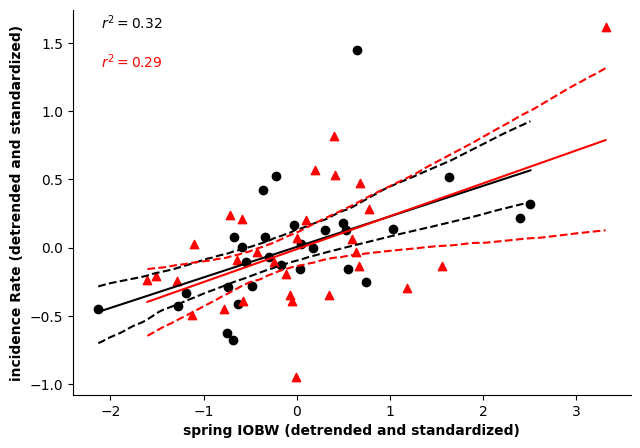

In [4]:
denv_iobw_df = pd.read_csv(os.path.join('data', 'Dengue_SpringIOBW.csv'))
north_df     = denv_iobw_df[denv_iobw_df['Hemisphere'] == 'N']
south_df     = denv_iobw_df[denv_iobw_df['Hemisphere'] == 'S']

fig, ax = plt.subplots(1, 1, figsize=(7.2, 5))

ax.scatter(north_df.IOBW_spring_detrend, north_df.IR_detrend,
                        marker = 'o',
                        color  = 'black')

x_north = north_df.IOBW_spring_detrend
y_north = north_df.IR_detrend

x_pred = np.linspace(x_north.min(), x_north.max(), 100)

y_mean, y_quant, r = linear_regression(x_north, y_north, num_bootstraps=300)
ax.plot(x_pred, y_mean, color='black', ls='-')
ax.plot(x_pred, y_quant[0], color='k', ls='--')
ax.plot(x_pred, y_quant[1], color='k', ls='--')

ax.text(0.05, 0.95, f'$r^2 = {(r**2).mean():.2f}$', transform=ax.transAxes)

x_south = south_df.IOBW_spring_detrend.values
y_south = south_df.IR_detrend.values
x_pred = np.linspace(x_south.min(), x_south.max(), 100)

y_mean, y_quant, r = linear_regression(x_south, y_south, num_bootstraps=500)

ax.scatter(south_df.IOBW_spring_detrend, south_df.IR_detrend,
                                                    marker = '^',
                                                    color  = 'red')

ax.plot(x_pred, y_quant[0], color='red', ls='--')
ax.plot(x_pred, y_quant[1], color='red', ls='--')
ax.plot(x_pred, y_mean, color='red', ls='-')

ax.text(0.05, 0.85, f'$r^2 = {(r**2).mean():.2f}$',
                        transform=ax.transAxes, color='red')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('incidence Rate (detrended and standardized)', weight='bold')
ax.set_xlabel('spring IOBW (detrended and standardized)', weight='bold')


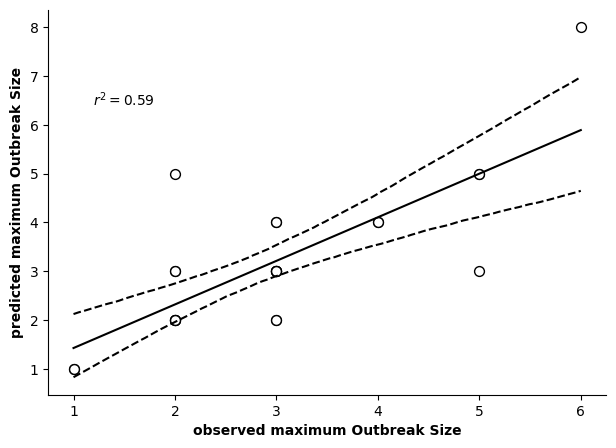

In [5]:
sim_denv_df = pd.read_csv(os.path.join('data', 'simulated_vs_obs.csv'))
x = sim_denv_df.max_outbreak_obs
y = sim_denv_df.max_outbreak_pre

fig, ax = plt.subplots(1, 1, figsize=(7.2, 5))


y_mean, y_quant, r = linear_regression(x,
                                        y, num_bootstraps=1000)

x_pred = np.linspace(x.min(), x.max(), 100)

ax.scatter(x, y, ec="k", color='white', s=50)
ax.plot(x_pred, y_quant[0], color='k', ls='--')
ax.plot(x_pred, y_quant[1], color='k', ls='--')
ax.plot(x_pred, y_mean, color='k', ls='-')

ax.text(0.08, 0.75, f'$r^2 = {(r**2).mean():.2f}$', transform=ax.transAxes, color='k')

ax.set_ylabel('predicted maximum Outbreak Size', weight='bold')
ax.set_xlabel('observed maximum Outbreak Size', weight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [102]:
def celcius2kelvin(temp):
    return temp + 273.15



/Users/chaosdonkey06/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/chaosdonkey06/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


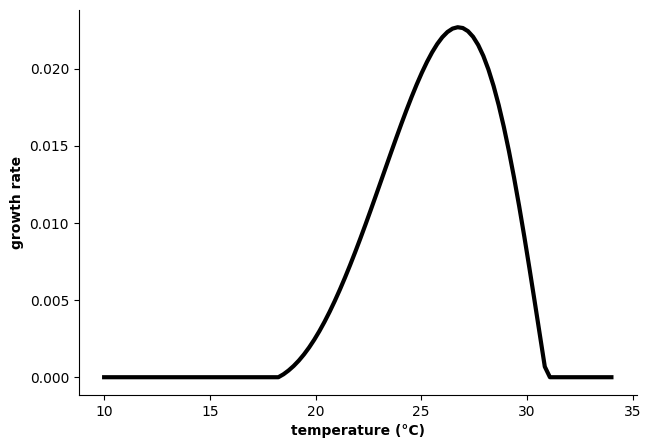

In [7]:
from scipy.special import lambertw

HbTopt = 0.8921
HTopt  = 298.3
Hs     = 3.085

HmTR  = 0.0138
HTR   = 297
HAm   = 13480
HTL   = 273
HAL   = -100000
HTH   = 303.8
HAH   = 48150
HdATR = 0.0029
HAdA  = 16824  # (* Adult Mortality *)
HAdJ  = 5743   # (* Juvenile Mortality *)
HdJTR = 0.0343

Hb  = lambda T: HbTopt * np.exp(-((T + 273) - HTopt)**2 / (2 * Hs**2))
Hm  = lambda T: HmTR*((T+273)/HTR)*np.exp(HAm*(1/HTR-1/(T+273)))/(1+np.exp(HAL*(1/HTL-1/(T+273)))+np.exp(HAH*(1/HTH-1/(T+273))))
HdA = lambda T: HdATR * np.exp(HAdA * (1 / HTR - 1 / (T + 273)))
HdJ = lambda T: HdJTR * np.exp(HAdJ * (1 / HTR - 1 / (T + 273)))

Hr = lambda T: - HdA(T) + Hm(T) * lambertw(Hb(T) / Hm(T) *np.exp((HdA(T) - HdJ(T)) / Hm(T)) )

temp = np.linspace(10, 34, 100)


fig, ax = plt.subplots(1, 1, figsize=(7.2, 5))

ax.plot(temp, np.maximum(Hr(temp), 0),
                    label="growth rate", color='black', lw=3)

ax.set_xlabel('temperature (°C)', weight='bold')
ax.set_ylabel('growth rate', weight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [125]:
exp1 = np.arange(24, 27+1, 0.5)
exp2 = np.arange(23, 28+1, 0.5)

σ2 = 0.001

exp1_gr = lambda num_reps: [[np.maximum(Hr(exp1), 0)+σ2*np.random.normal(0, 1, len(exp1))] for i_rep in range(num_reps)]
exp2_gr = lambda num_reps: [[np.maximum(Hr(exp2), 0)+σ2*np.random.normal(0, 1, len(exp2))] for i_rep in range(num_reps)]

exp1_gr = np.squeeze(np.array(exp1_gr(3)))
exp2_gr = np.squeeze(np.array(exp2_gr(3)))


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_55588/1583014746.py:5: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(exp1[0], exp1_gr[0, 0], fc='k', lw=1, marker=markers[0], ec="k", label="replicate 1")
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_55588/1583014746.py:16: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(exp1, exp1_gr[i, :], fc="red", lw=1, marker=markers[i], ec="red", label=label1)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_55588/1583014746.py:17: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may chan

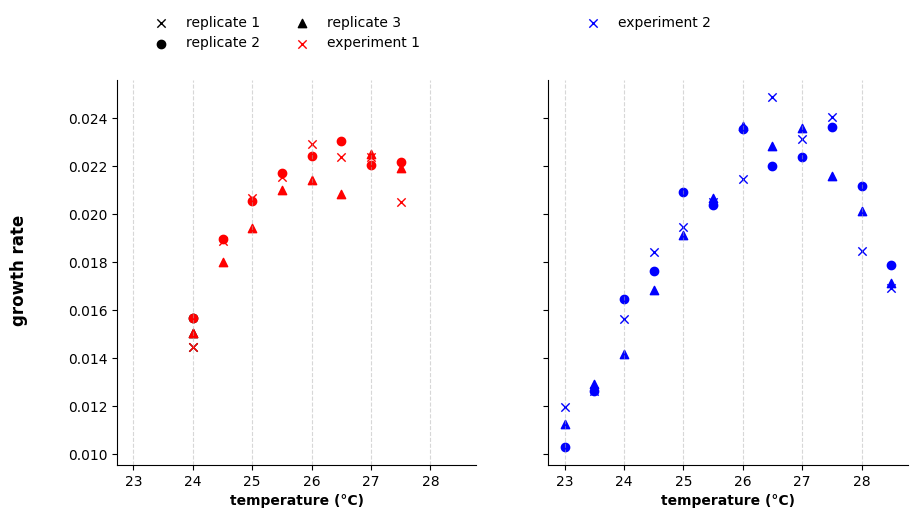

In [131]:
markers = ['x', 'o', '^']

fig, ax = plt.subplots(1, 2, figsize=(10.2, 5), sharex=True, sharey=True)

ax[0].scatter(exp1[0], exp1_gr[0, 0], fc='k', lw=1, marker=markers[0], ec="k", label="replicate 1")
ax[0].scatter(exp1[0], exp1_gr[1, 0], fc='k', lw=1, marker=markers[1], ec="k", label="replicate 2")
ax[0].scatter(exp1[0], exp1_gr[2, 0], fc='k', lw=1, marker=markers[2], ec="k", label="replicate 3")

for i in range(3):
    if i==0:
        label1 = "experiment 1"
        label2 = "experiment 2"
    else:
        label1 = None
        label2 = None
    ax[0].scatter(exp1, exp1_gr[i, :], fc="red", lw=1, marker=markers[i], ec="red", label=label1)
    ax[1].scatter(exp2, exp2_gr[i, :], fc="blue", lw=1, marker=markers[i], ec="blue", label=label2)

for axi in ax.flatten():
    axi.legend(loc="upper left", ncol=2, bbox_to_anchor=(0.05, 1.2), frameon=False)
    axi.set_xlabel('temperature (°C)', weight='bold')
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

    axi.grid(axis='x', ls='--', alpha=0.5)
fig.supylabel('growth rate', weight='bold')


fig.savefig('figures/sim_experiment_gr.png', dpi=300, bbox_inches='tight')


In [127]:
exp1_df = []
exp2_df = []

for i in range(3):
    data1 = {'temperature': list(exp1)*3,
            'growth_rate': list(exp1_gr[0, :])+list(exp1_gr[1, :])+list(exp1_gr[2, :]),
            'experiment': 1}

    data2 = {'temperature': list(exp2)*3,
            'growth_rate': list(exp2_gr[0, :])+list(exp2_gr[1, :])+list(exp2_gr[2, :]),
            'experiment': 2}

    exp1_df.append(pd.DataFrame(data1))
    exp2_df.append(pd.DataFrame(data2))

exp1_df                = pd.concat(exp1_df)
exp1_df["growth_rate"] = exp1_df["growth_rate"].apply(lambda x: np.real(x))

exp2_df                = pd.concat(exp2_df)
exp2_df["growth_rate"] = exp2_df["growth_rate"].apply(lambda x: np.real(x))


y_mean1, y_quant1, r1 = linear_regression(exp1_df.temperature.values, exp1_df.growth_rate.values, num_bootstraps=500)
y_mean2, y_quant2, r2 = linear_regression(exp2_df.temperature.values, exp2_df.growth_rate.values, num_bootstraps=500)


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_55588/3414611011.py:12: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(exp1, exp1_gr[i, :], fc="red", lw=1, marker=markers[i], ec="red")
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_55588/3414611011.py:13: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[1].scatter(exp2, exp2_gr[i, :], fc="blue", lw=1, marker=markers[i], ec="blue")


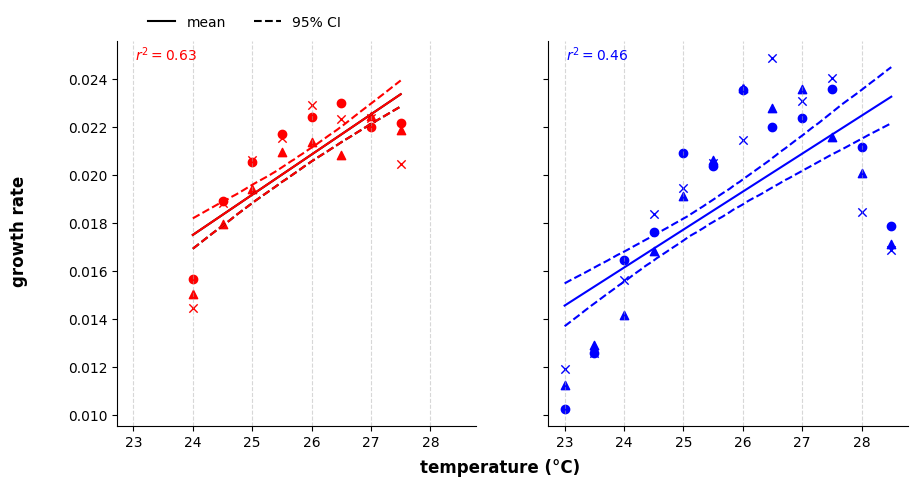

In [130]:
markers = ['x', 'o', '^']

fig, ax = plt.subplots(1, 2, figsize=(10.2, 5), sharex=True, sharey=True)

for i in range(3):
    if i==0:
        label1 = "experiment 1"
        label2 = "experiment 2"
    else:
        label1 = None
        label2 = None
    ax[0].scatter(exp1, exp1_gr[i, :], fc="red", lw=1, marker=markers[i], ec="red")
    ax[1].scatter(exp2, exp2_gr[i, :], fc="blue", lw=1, marker=markers[i], ec="blue")

x_pred  = np.linspace(exp1.min(), exp1.max(), 100)
x_pred2 = np.linspace(exp2.min(), exp2.max(), 100)

ax[0].plot(x_pred, y_mean1, color='k', ls='-', label="mean")
ax[0].plot(x_pred, y_quant1[0], color='k', ls='--', label="95% CI")


ax[0].plot(x_pred, y_mean1, color='red', ls='-')
ax[0].plot(x_pred, y_quant1[0], color='red', ls='--')
ax[0].plot(x_pred, y_quant1[1], color='red', ls='--')


ax[1].plot(x_pred2, y_mean2, color='blue', ls='-')
ax[1].plot(x_pred2, y_quant2[0], color='blue', ls='--')
ax[1].plot(x_pred2, y_quant2[1], color='blue', ls='--')

ax[0].legend(loc="upper left", ncol=2, bbox_to_anchor=(0.05, 1.1), frameon=False)

ax[0].text(0.05, 0.95, f'$r^2 = {(r1**2).mean():.2f}$', transform=ax[0].transAxes, color='red')
ax[1].text(0.05, 0.95, f'$r^2 = {(r2**2).mean():.2f}$', transform=ax[1].transAxes, color='blue')

for axi in ax.flatten():
    axi.grid(axis='x', ls='--', alpha=0.5)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

fig.supylabel('growth rate', weight='bold')
fig.supxlabel('temperature (°C)', weight='bold')

fig.savefig('figures/figure_change_r2.png', dpi=300, bbox_inches='tight')


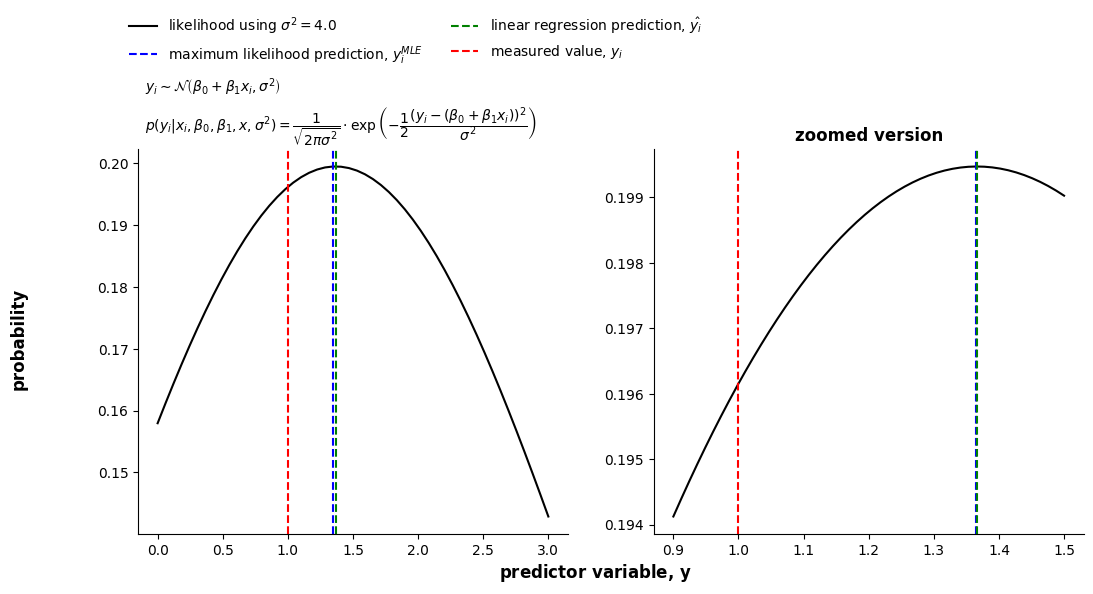

In [120]:

def likelihood_observation(yi, yhat, σ2):
    lik = 1/(np.sqrt(2*np.pi*σ2)) * np.exp(-0.5*(yi-yhat)**2/σ2)
    return lik


sim_denv_df = pd.read_csv(os.path.join('data', 'simulated_vs_obs.csv'))
x = sim_denv_df.max_outbreak_obs
y = sim_denv_df.max_outbreak_pre

β1, β0, r_value, p_value, std_err = linregress(x, y)
y_hat = β0 + β1*x

y_range       = np.linspace(0, 3)
likelihood_yi = likelihood_observation(y_range, y_hat[0], σ2=4)

fig, ax = plt.subplots(1, 2, figsize=(12.2, 5))

ax[0].plot(y_range, likelihood_yi, color='black', label=r"likelihood using $\sigma^2 =${:0.01f}".format(4))
ax[0].axvline(y_range[np.argmax(likelihood_yi)], color='blue', ls='--', label=r"maximum likelihood prediction, ${y}^{MLE}_i$")
ax[0].axvline(y_hat[0], color='green', ls='--', label=r"linear regression prediction, $\hat{y_i}$")
ax[0].axvline(y[0],     color='red', ls='--', label=r"measured value, $y_i$")


y_range       = np.linspace(0.9, 1.5)
likelihood_yi = likelihood_observation(y_range, y_hat[0], σ2=4)

ax[1].plot(y_range, likelihood_yi, color='black', label=r"likelihood using $\sigma^2 =${:0.01f}".format(4))
ax[1].axvline(y_range[np.argmax(likelihood_yi)], color='blue', ls='--', label=r"maximum likelihood prediction, ${y}^{MLE}_i$")
ax[1].axvline(y_hat[0], color='green', ls='--', label=r"linear regression prediction, $\hat{y_i}$")
ax[1].axvline(y[0],     color='red', ls='--', label=r"measured value, $y_i$")


ax[0].text(x = 0.015, y=1.15,
        s = r'$y_i\sim \mathcal{{N}}\left(\beta_0+\beta_1 x_i,\sigma^2\right)$',
        transform = ax[0].transAxes)
ax[0].text(0.015, 1.05,
        r'$p(y_i|x_i,\beta_0,\beta_1,x,\sigma^2)=\dfrac{1}{\sqrt{2 \pi \sigma^2} }\cdot \exp\left(-\dfrac{1}{2}\dfrac{\left(y_i-(\beta_0+\beta_1 x_i)\right)^2}{\sigma^2}\right)$',
        transform = ax[0].transAxes)

ax[0].legend(ncol=2, loc='upper left', bbox_to_anchor=(-0.05, 1.38), frameon=False)

ax[1].set_title('zoomed version', weight='bold')

fig.supxlabel(r'predictor variable, $\mathbf{y}$', weight='bold')
fig.supylabel(r'probability', weight='bold')

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

fig.savefig('figures/likelihood_yi.png', dpi=300, bbox_inches='tight')